# Is Markowitz portfolio optimization really optimal?
In this notebook I will simulate if a Markowitz mean-variance (MV) optimal portfolio would have been a good choice for an investor.
This will be done by:
1. Sourcing real world price data from differnt US stocks for year 2020
2. calculation the input parameters for MV-optimization 
3. deriving the optimal portfolio selection 
4. backtesting the performance of this portfolio for the year 2020

In these first steps the input parameters (means and variance-covariance matrix) are assumed to be known (like in the original paper of Markowitz). Obviously, in reality, the moments of the assets' return distributions are stochastic. In the second part, it will be shown how a naively MV-optimized portfolio would have behaved for an out-of-sample period.

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Data
First of all the data will be sourced from yahoo finance API.

In [4]:
prices = pd.read_excel('PriceData.xlsx').drop('Unnamed: 0', axis=1)
prices

,TICKER,as_of_date,close
0,AAPL,2020-01-02,75.087502
1,AAPL,2020-01-03,74.357498
2,AAPL,2020-01-06,74.949997
3,AAPL,2020-01-07,74.597504
4,AAPL,2020-01-08,75.797501
...,...,...,...
12839,ZM,2020-12-16,404.000000
12840,ZM,2020-12-17,401.619995
12841,ZM,2020-12-18,406.010010
12842,ZM,2020-12-21,408.970001


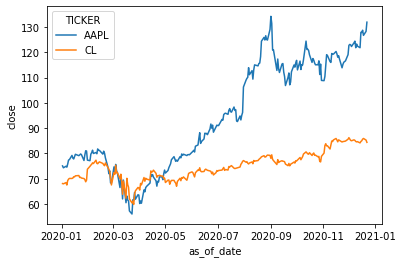

In [5]:
sns.lineplot(data=prices[prices['TICKER'].isin(['AAPL', 'CL'])], x='as_of_date', y='close', hue='TICKER');

### pivot prices
Change the structure of the dataframe for further analysis.

In [6]:
prices = pd.pivot(prices, index=['as_of_date'], values='close', columns=['TICKER'])
prices

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
as_of_date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,75.087502,49.099998,240.100006,1898.010010,58.650002,219.770004,2074.580078,508.980011,83.449997,112.260002,...,151.619995,63.830002,60.500000,210.449997,129.570007,57.020000,114.220001,102.169998,149.199997,68.720001
2020-01-03,74.357498,48.599998,238.470001,1874.969971,58.669998,217.000000,2065.479980,503.570007,82.750000,112.290001,...,152.500000,63.000000,58.910000,209.589996,127.849998,56.939999,115.330002,101.849998,148.809998,67.279999
2020-01-06,74.949997,48.389999,240.300003,1902.880005,59.740002,216.639999,2047.400024,504.000000,83.330002,112.800003,...,156.720001,62.570000,58.209999,212.220001,126.959999,57.000000,115.930000,101.790001,147.949997,70.320000
2020-01-07,74.597504,48.250000,238.039993,1906.859985,60.340000,217.630005,2068.050049,507.220001,81.610001,112.029999,...,156.020004,64.589996,58.910000,209.619995,129.410004,56.080002,116.010002,101.970001,147.820007,71.900002
2020-01-08,75.797501,47.830002,238.220001,1891.969971,59.880001,218.000000,2062.899902,507.100006,81.980003,111.480003,...,158.779999,67.599998,59.369999,210.690002,129.759995,55.840000,116.080002,102.150002,149.589996,72.550003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,127.809998,96.849998,228.440002,3240.959961,88.220001,261.890015,2098.709961,698.369995,70.180000,120.760002,...,318.529999,227.080002,66.309998,235.130005,162.119995,59.380001,116.080002,107.419998,148.850006,404.000000
2020-12-17,128.699997,96.839996,231.240005,3236.080078,88.459999,264.429993,2113.429932,706.010010,71.449997,119.629997,...,328.059998,230.740005,66.209999,238.100006,162.690002,59.259998,117.510002,108.790001,151.360001,401.619995
2020-12-18,126.660004,95.919998,228.490005,3201.649902,90.370003,260.000000,2099.649902,698.799988,71.500000,122.250000,...,336.100006,235.449997,64.720001,240.000000,164.070007,58.790001,117.410004,109.779999,151.850006,406.010010


Plot if the price data has any meaningful NaNs.

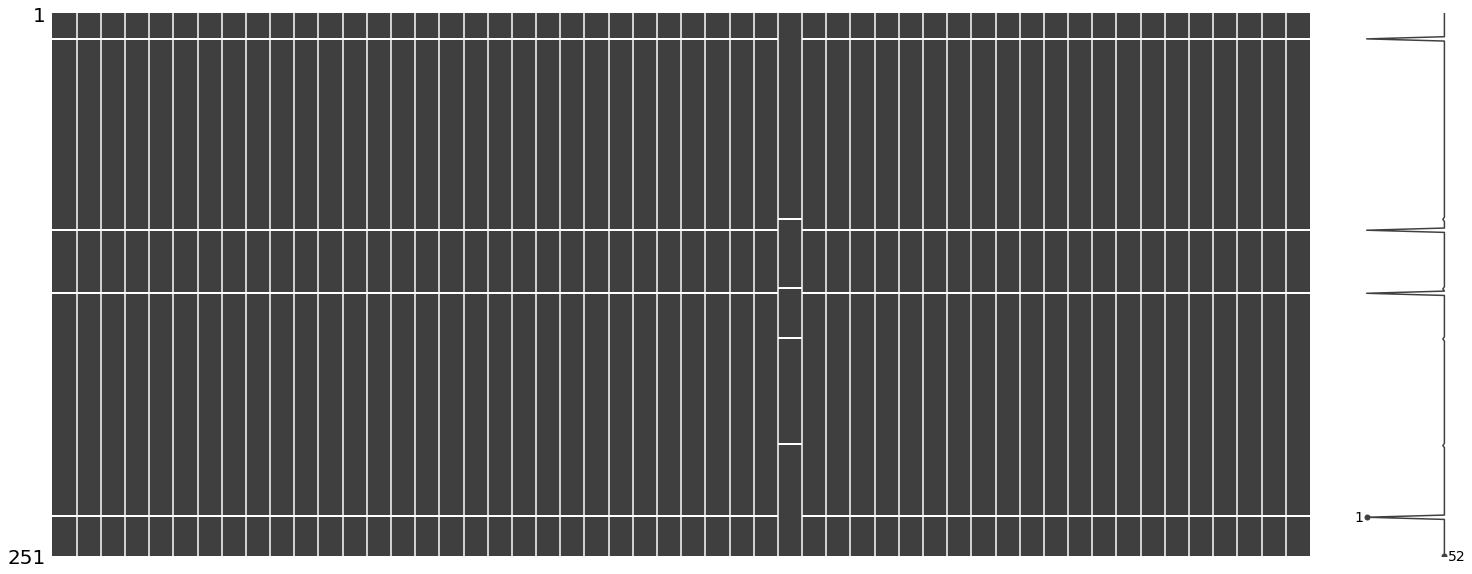

In [7]:
import missingno
missingno.matrix(prices);

## get returns
For MV analysis the price moves need to be converted into returns.

In [8]:
def log_return(prices):
    return np.log(prices / prices.shift(1))

def arithmetic_returns(prices): 
    return prices/prices.shift(1) - 1

For this analysis, it should be preferred to use logarithmic returns. That's because, mathematically, the daily logarithmic returns are viewed as a series of i.i.d. random variables. This given, we can easily derive the annual return distribution and their moments, as the daily logarithmic returns sum up to the annual returns. That's not the case for arithmetic returns.

Look at: https://www.anevis-solutions.com/de/2016/calculate-volatility-correctly/ for further details.

In [9]:
returns = log_return(prices=prices).dropna()

In [10]:
# scale returns in order to interpret them as % values
returns = returns * 100
returns

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
as_of_date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.976960,-1.023550,-0.681201,-1.221333,0.034089,-1.268421,-0.439613,-1.068600,-0.842360,0.026719,...,0.578724,-1.308860,-2.663251,-0.409486,-1.336364,-0.140403,0.967118,-0.313695,-0.261736,-2.117730
2020-01-06,0.793667,-0.433033,0.764463,1.477589,1.807335,-0.166037,-0.879193,0.085352,0.698464,0.453155,...,2.729619,-0.684880,-1.195371,1.247025,-0.698562,0.105321,0.518896,-0.058925,-0.579595,4.419325
2020-01-07,-0.471414,-0.289734,-0.944946,0.208937,0.999340,0.455941,1.003545,0.636857,-2.085684,-0.684968,...,-0.447655,3.177362,1.195371,-1.232713,1.911362,-1.627199,0.068985,0.176679,-0.087899,2.222004
2020-01-08,1.595827,-0.874273,0.075592,-0.783930,-0.765266,0.169867,-0.249345,-0.023660,0.452355,-0.492145,...,1.753536,4.554842,0.777818,0.509153,0.270086,-0.428881,0.060321,0.176367,1.190283,0.899974
2020-01-09,2.101837,2.355479,0.297597,0.478779,-0.905896,1.719083,1.031558,1.176248,-1.227310,0.206099,...,-0.657145,0.486981,1.819294,0.445162,1.202671,0.642631,0.043061,0.789822,-0.664002,0.096438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,-0.054754,-0.278398,-0.910740,2.367856,1.484557,2.622980,0.031449,0.027210,-0.794778,-1.943556,...,-2.615177,3.172027,0.498896,0.456109,-0.160253,1.801240,-0.601219,0.037245,0.701148,1.137637
2020-12-17,0.693932,-0.010328,1.218255,-0.150683,0.271675,0.965191,0.698934,1.088037,1.793449,-0.940150,...,2.947985,1.598917,-0.150918,1.255221,0.350979,-0.202297,1.224383,1.267306,1.672198,-0.590852
2020-12-18,-1.597773,-0.954560,-1.196369,-1.069647,2.136192,-1.689491,-0.654157,-1.026485,0.069959,2.166451,...,2.421224,2.020700,-2.276120,0.794814,0.844665,-0.796273,-0.085134,0.905893,0.323212,1.087146


In [11]:
returns.cumsum()

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
as_of_date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.976960,-1.023550,-0.681201,-1.221333,0.034089,-1.268421,-0.439613,-1.068600,-0.842360,0.026719,...,0.578724,-1.308860,-2.663251,-0.409486,-1.336364,-0.140403,0.967118,-0.313695,-0.261736,-2.117730
2020-01-06,-0.183294,-1.456584,0.083263,0.256256,1.841424,-1.434458,-1.318805,-0.983248,-0.143896,0.479874,...,3.308342,-1.993740,-3.858622,0.837540,-2.034926,-0.035082,1.486014,-0.372620,-0.841331,2.301595
2020-01-07,-0.654708,-1.746318,-0.861683,0.465193,2.840764,-0.978517,-0.315260,-0.346391,-2.229580,-0.205095,...,2.860687,1.183622,-2.663251,-0.395174,-0.123565,-1.662282,1.554999,-0.195941,-0.929230,4.523599
2020-01-08,0.941120,-2.620591,-0.786091,-0.318738,2.075498,-0.808650,-0.564605,-0.370051,-1.777226,-0.697240,...,4.614223,5.738463,-1.885433,0.113979,0.146522,-2.091163,1.615320,-0.019574,0.261053,5.423573
2020-01-09,3.042957,-0.265111,-0.488494,0.160042,1.169602,0.910433,0.466953,0.806197,-3.004536,-0.491141,...,3.957078,6.225444,-0.066139,0.559141,1.349192,-1.448532,1.658381,0.770248,-0.402949,5.520011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,43.243389,55.027075,-7.075754,36.612468,31.128682,-5.155929,-18.617874,25.503629,-34.851501,1.831022,...,56.639442,111.306118,3.609059,6.190089,8.201612,2.388500,-2.537873,-2.116517,-6.551612,161.107010
2020-12-17,43.937321,55.016747,-5.857499,36.461786,31.400358,-4.190738,-17.918941,26.591666,-33.058052,0.890872,...,59.587427,112.905035,3.458141,7.445310,8.552591,2.186203,-1.313490,-0.849212,-4.879414,160.516157
2020-12-18,42.339548,54.062187,-7.053868,35.392138,33.536550,-5.880229,-18.573098,25.565181,-32.988093,3.057322,...,62.008652,114.925735,1.182020,8.240124,9.397256,1.389930,-1.398624,0.056681,-4.556202,161.603303


In [12]:
# returns (logarithmic) annual
print('AAPL', round(np.log(prices['AAPL'][-1] / prices['AAPL'][0]), 2) ) ## performance AAPL in the year
print('ZM', round(np.log(prices['ZM'][-1] / prices['ZM'][0]), 2))  ## performance ZM in the year

AAPL 0.56
ZM 1.78


As the daily logarithmic returns sum up to the annual logarithmic returns, the cumsum of retruns should equal the values calculated in the last code block. In fact, that's the case.

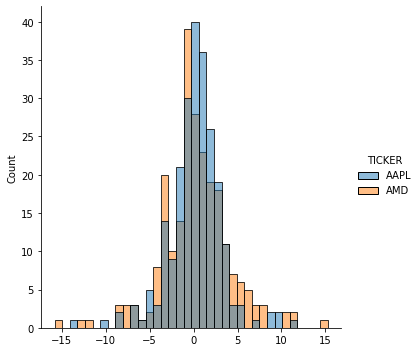

In [13]:
sns.displot(returns.iloc[:, :2]);

## get correlations, covariances, means & stds of returns

In [14]:
correlation_matrix = returns.corr()
correlation_matrix

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
TICKER,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.685339,0.654108,0.710899,0.634099,0.553964,0.523197,0.675486,0.381985,0.612092,...,0.430500,0.628906,0.576320,0.566877,0.748324,0.554245,0.592219,0.523282,0.457626,0.087926
AMD,0.685339,1.000000,0.552575,0.651867,0.590628,0.465602,0.428050,0.491618,0.334662,0.551749,...,0.389686,0.582738,0.432124,0.461806,0.689934,0.463806,0.465933,0.409729,0.360018,0.155233
AMGN,0.654108,0.552575,1.000000,0.547279,0.571554,0.411065,0.441989,0.623394,0.362333,0.570273,...,0.292408,0.397299,0.549602,0.520964,0.709157,0.589004,0.610665,0.409049,0.408404,-0.051874
AMZN,0.710899,0.651867,0.547279,1.000000,0.636030,0.537822,0.339777,0.477225,0.279342,0.556022,...,0.439281,0.520966,0.405205,0.320977,0.650486,0.452835,0.366407,0.284788,0.268440,0.265390
ATVI,0.634099,0.590628,0.571554,0.636030,1.000000,0.410261,0.247089,0.439369,0.239106,0.487469,...,0.344082,0.481971,0.424048,0.309578,0.605363,0.432174,0.346007,0.162107,0.147487,0.266049
BABA,0.553964,0.465602,0.411065,0.537822,0.410261,1.000000,0.416014,0.495565,0.342518,0.419308,...,0.368421,0.528186,0.398547,0.411690,0.578007,0.399266,0.324901,0.355566,0.334457,0.170505
BKNG,0.523197,0.428050,0.441989,0.339777,0.247089,0.416014,1.000000,0.620181,0.645915,0.519009,...,0.291092,0.500491,0.526953,0.681655,0.624645,0.449733,0.578141,0.596805,0.642314,-0.192720
BLK,0.675486,0.491618,0.623394,0.477225,0.439369,0.495565,0.620181,1.000000,0.500252,0.557668,...,0.340647,0.591691,0.651424,0.757241,0.707650,0.694304,0.702518,0.679217,0.636551,-0.082135
BUD,0.381985,0.334662,0.362333,0.279342,0.239106,0.342518,0.645915,0.500252,1.000000,0.374959,...,0.221878,0.414807,0.497441,0.543865,0.531542,0.428785,0.488893,0.483817,0.571857,-0.134136


In [15]:
var_covariance_matrix = returns.cov()
var_covariance_matrix

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
TICKER,,,,,,,,,,,,,,,,,,,,,
AAPL,8.999225,8.018355,4.716114,5.192370,4.730107,3.997089,5.056065,6.301536,3.686016,4.097469,...,4.483909,9.005783,4.863687,5.411455,6.226530,3.437177,4.019576,4.413717,4.358722,1.395188
AMD,8.018355,15.210873,5.179659,6.190006,5.727991,4.367690,5.377947,5.962557,4.198481,4.801914,...,5.276835,10.848846,4.741163,5.731382,7.463433,3.739473,4.111459,4.493039,4.458084,3.202385
AMGN,4.716114,5.179659,5.776505,3.202551,3.415866,2.376311,3.422070,4.659324,2.801227,3.058520,...,2.440071,4.558091,3.716037,3.984404,4.727471,2.926499,3.320712,2.764231,3.116516,-0.659465
AMZN,5.192370,6.190006,3.202551,5.928024,3.850737,3.149583,2.664978,3.613312,2.187758,3.020946,...,3.713457,6.054774,2.775422,2.486862,4.392857,2.279253,2.018433,1.949589,2.075143,3.417844
ATVI,4.730107,5.727991,3.415866,3.850737,6.183328,2.453752,1.979288,3.397564,1.912540,2.704922,...,2.970670,5.720911,2.966367,2.449652,4.175237,2.221604,1.946664,1.133389,1.164422,3.499329
BABA,3.997089,4.367690,2.376311,3.149583,2.453752,5.785213,3.223390,3.706701,2.650035,2.250549,...,3.076698,6.064295,2.696735,3.151034,3.856086,1.985269,1.768094,2.404621,2.554147,2.169248
BKNG,5.056065,5.377947,3.422070,2.664978,1.979288,3.223390,10.377434,6.212850,6.693120,3.730923,...,3.255790,7.696170,4.775470,6.987667,5.581263,2.995001,4.213800,5.405597,6.569599,-3.283862
BLK,6.301536,5.962557,4.659324,3.613312,3.397564,3.706701,6.212850,9.670632,5.004084,3.869894,...,3.678010,8.783269,5.698889,7.493496,6.103791,4.463488,4.942878,5.938847,6.285029,-1.351034
BUD,3.686016,4.198481,2.801227,2.187758,1.912540,2.650035,6.693120,5.004084,10.347046,2.691459,...,2.478010,6.369240,4.501418,5.567016,4.742419,2.851317,3.558095,4.375781,5.840391,-2.282257


In [16]:
returns.describe().iloc[returns.describe().index.isin(['mean', 'std']), :]

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
mean,0.198197,0.218558,-0.044408,0.151898,0.138802,-0.032039,-0.089012,0.106012,-0.152178,0.050430,...,0.246626,0.502119,-0.00167,0.026744,0.036103,0.000306,-0.004125,-0.009125,-0.022351,0.693748
std,2.999871,3.900112,2.403436,2.434753,2.486630,2.405247,3.221403,3.109764,3.216682,2.231496,...,3.472012,4.773461,2.81319,3.182165,2.773665,2.067271,2.262535,2.811684,3.175019,5.289474


annualized means:

In [17]:
means = (returns.mean()) * 252
means

TICKER
AAPL       49.945708
AMD        55.076631
AMGN      -11.190703
AMZN       38.278300
ATVI       34.978189
BABA       -8.073773
BKNG      -22.430919
BLK        26.714946
BUD       -38.348764
CHKP       12.708460
CL         23.945101
CMG        42.099352
CSCO      -10.012200
DEO        -8.829585
DIS         2.812989
DLB        13.602058
DPZ        26.422200
EA         19.003444
FB         14.609421
FIZZ       56.040566
GOOG       14.090862
H         -46.411397
INTC      -40.748644
IRBT       39.625064
ISRG       25.932484
JNJ         4.456205
KHC        -2.327309
MA          0.040501
MCD        -3.344941
MCO        13.384105
MENE.V     51.843038
MMM       -13.465227
MO        -17.579191
MSCI       55.044111
MSFT       24.898532
NFLX       37.926480
NVDA       72.193958
PEP         4.937771
PG          8.850460
PTON      182.995140
PYPL       81.713325
SBUX       11.949915
SPOT       62.149775
SQ        126.534098
STX        -0.420923
SYK         6.739501
TXN         9.097894
UL    

annualized standard deviations:

In [18]:
stds = (returns.std()) * np.sqrt(252)
stds

TICKER
AAPL       47.621472
AMD        61.912358
AMGN       38.153366
AMZN       38.650512
ATVI       39.474025
BABA       38.182111
BKNG       51.138180
BLK        49.365972
BUD        51.063252
CHKP       35.423905
CL         32.564265
CMG        50.374001
CSCO       43.341735
DEO        38.027478
DIS        49.547081
DLB        44.436404
DPZ        42.808633
EA         37.177629
FB         47.055233
FIZZ       47.667309
GOOG       39.470427
H          66.862869
INTC       55.500721
IRBT       63.002370
ISRG       47.067136
JNJ        31.285649
KHC        44.557815
MA         50.007533
MCD        41.286879
MCO        51.922268
MENE.V    100.514984
MMM        37.929490
MO         37.113912
MSCI       53.407432
MSFT       45.121065
NFLX       46.804428
NVDA       59.889528
PEP        37.966229
PG         33.307645
PTON       75.197503
PYPL       53.787662
SBUX       47.096690
SPOT       55.116482
SQ         75.776352
STX        44.658011
SYK        50.515308
TXN        44.030562
UL    

# Portfolio Optimization Part

In this parto fo the notebook, it is assumed that for the given period (CY 2020), the population moments (return and volatility) for all assets are known in advance.

We now have calculated the means and cov-matrix of the given assets. We will now derive an optimal portfolio allocation (maximization of sharpe ratio) based on those statistics. Furthermore, given the mean return of the equally-weighted (trivial) portfolio, a variance-minimizing portfolio will be calculated.

The performance of these 3 portfolios will be compared afterwards.

## Implementation scipy

In [19]:
df_returns = returns.copy()
returns = returns.T.values

In [20]:
def portfolio_return(weights, returns):
    return np.sum(np.mean(returns, axis=1) * weights) * 252

def portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(np.cov(returns) * 252, weights)))


In [21]:
import scipy.optimize as minimizer

def sharpe_taget(weights, *args):
    # get the asset's returns 
    returns = args[0]

    #print(portfolio_return(weights, returns))
    #print(portfolio_volatility(weights, returns))
    return - portfolio_return(weights, returns) / portfolio_volatility(weights, returns)

# this equality constraint makes sure that the weights of the single assets sum to 1 for the total portfolio
cons = ({'type': 'eq', 
         'fun': lambda x: np.sum(x) - 1
         })

bounds = tuple((0, 1) for x in range(len(returns)))

equally_weighted_portfolio = np.array([1 / len(returns) for x in range(len(returns))])


In [22]:
sharpe_taget(equally_weighted_portfolio, returns)

-0.7173742401379394

## Maximization of sharpe ratio
Scipy's implementation of optimize.minimze enables the target function to receive additional parameters other than the independent variables. This is achieved by defining the *args.

In [23]:
%%time
opts = minimizer.minimize(sharpe_taget, x0=equally_weighted_portfolio, args=returns, method="SLSQP", bounds=bounds, constraints=cons)

CPU times: user 254 ms, sys: 8.14 ms, total: 262 ms
Wall time: 330 ms


In [24]:
optimal_portfolio = opts['x'].round(3)

## Minimization of variance for given level of return

In [25]:
def taget_fun(weights, *args):
    # get the asset's returns 
    returns = args[0]

    return portfolio_volatility(weights, returns)

# specify target level of return 
return_target = portfolio_return(equally_weighted_portfolio, returns)

# the first equality constraint makes sure that the weights of the single assets sum to 1 for the total portfolio
# the second constraint fixes the return level which the total portfolio should achieve
cons = ({'type': 'eq', 
         'fun': lambda x: np.sum(np.mean(returns, axis=1) * x) * 252 - return_target
         },
         {
         'type': 'eq', 
         'fun': lambda x: np.sum(x) - 1
         
         })

bounds = tuple((0, 1) for x in range(len(returns)))

equally_weighted_portfolio = np.array([1 / len(returns) for x in range(len(returns))])


In [26]:
%%time
opts = minimizer.minimize(taget_fun, x0=equally_weighted_portfolio, args=returns, method="SLSQP", bounds=bounds, constraints=cons)

CPU times: user 525 ms, sys: 10.1 ms, total: 535 ms
Wall time: 327 ms


In [27]:
min_var_portfolio = opts['x'].round(3)
min_var_portfolio

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.081, 0.   , 0.   , 0.   ,
       0.044, 0.007, 0.   , 0.   , 0.063, 0.   , 0.   , 0.151, 0.035,
       0.   , 0.04 , 0.   , 0.015, 0.   , 0.   , 0.   , 0.254, 0.   ,
       0.   , 0.   , 0.   , 0.05 , 0.04 , 0.113, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.007, 0.   , 0.   , 0.003, 0.   , 0.   ,
       0.   , 0.   , 0.011, 0.001, 0.   , 0.   , 0.083])

## Compare the first 2 moments of the equally weighted portfolio vs. the Markowitz portfolio.

In [28]:
print(df_returns.columns)

Index(['AAPL', 'AMD', 'AMGN', 'AMZN', 'ATVI', 'BABA', 'BKNG', 'BLK', 'BUD',
       'CHKP', 'CL', 'CMG', 'CSCO', 'DEO', 'DIS', 'DLB', 'DPZ', 'EA', 'FB',
       'FIZZ', 'GOOG', 'H', 'INTC', 'IRBT', 'ISRG', 'JNJ', 'KHC', 'MA', 'MCD',
       'MCO', 'MENE.V', 'MMM', 'MO', 'MSCI', 'MSFT', 'NFLX', 'NVDA', 'PEP',
       'PG', 'PTON', 'PYPL', 'SBUX', 'SPOT', 'SQ', 'STX', 'SYK', 'TXN', 'UL',
       'WM', 'YUM', 'ZBH', 'ZM'],
      dtype='object', name='TICKER')


In [29]:
print('Allocation Optimal', optimal_portfolio)
print(portfolio_return(optimal_portfolio, returns))
print(portfolio_volatility(optimal_portfolio, returns))
print('Sharpe Ratio', -round(sharpe_taget(optimal_portfolio, returns), 2))

Allocation Optimal [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.258 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.067 0.    0.    0.    0.    0.
 0.    0.    0.    0.322 0.    0.    0.005 0.142 0.    0.    0.    0.
 0.    0.    0.    0.206]
131.14882274636275
43.37855681951548
Sharpe Ratio 3.02


In [30]:
print('Allocation Trivial', equally_weighted_portfolio)
print(portfolio_return(equally_weighted_portfolio, returns))
print(portfolio_volatility(equally_weighted_portfolio, returns))
print('Sharpe Ratio', -round(sharpe_taget(equally_weighted_portfolio, returns), 2))

Allocation Trivial [0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077]
22.94975418686903
31.991327403192184
Sharpe Ratio 0.72


In [31]:
print('Minimal variance allocation given target return', min_var_portfolio)
print(portfolio_return(min_var_portfolio, returns))
print(portfolio_volatility(min_var_portfolio, returns))
print('Sharpe Ratio', -round(sharpe_taget(min_var_portfolio, returns), 2))

Minimal variance allocation given target return [0.    0.    0.    0.    0.    0.081 0.    0.    0.    0.044 0.007 0.
 0.    0.063 0.    0.    0.151 0.035 0.    0.04  0.    0.015 0.    0.
 0.    0.254 0.    0.    0.    0.    0.05  0.04  0.113 0.    0.    0.
 0.    0.    0.    0.007 0.    0.    0.003 0.    0.    0.    0.    0.011
 0.001 0.    0.    0.083]
22.89350004708639
22.98954242313424
Sharpe Ratio 1.0


# Performance comparison for scipy

In [32]:
# Plot performance of trivial portfolio vs optiaml portfolio
trivial_portfolio = equally_weighted_portfolio
markowitz_portfolio = optimal_portfolio
min_var_portfolio = min_var_portfolio  # unnecessary

df_performance = pd.DataFrame()

In [33]:
df_returns

TICKER,AAPL,AMD,AMGN,AMZN,ATVI,BABA,BKNG,BLK,BUD,CHKP,...,SPOT,SQ,STX,SYK,TXN,UL,WM,YUM,ZBH,ZM
as_of_date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.976960,-1.023550,-0.681201,-1.221333,0.034089,-1.268421,-0.439613,-1.068600,-0.842360,0.026719,...,0.578724,-1.308860,-2.663251,-0.409486,-1.336364,-0.140403,0.967118,-0.313695,-0.261736,-2.117730
2020-01-06,0.793667,-0.433033,0.764463,1.477589,1.807335,-0.166037,-0.879193,0.085352,0.698464,0.453155,...,2.729619,-0.684880,-1.195371,1.247025,-0.698562,0.105321,0.518896,-0.058925,-0.579595,4.419325
2020-01-07,-0.471414,-0.289734,-0.944946,0.208937,0.999340,0.455941,1.003545,0.636857,-2.085684,-0.684968,...,-0.447655,3.177362,1.195371,-1.232713,1.911362,-1.627199,0.068985,0.176679,-0.087899,2.222004
2020-01-08,1.595827,-0.874273,0.075592,-0.783930,-0.765266,0.169867,-0.249345,-0.023660,0.452355,-0.492145,...,1.753536,4.554842,0.777818,0.509153,0.270086,-0.428881,0.060321,0.176367,1.190283,0.899974
2020-01-09,2.101837,2.355479,0.297597,0.478779,-0.905896,1.719083,1.031558,1.176248,-1.227310,0.206099,...,-0.657145,0.486981,1.819294,0.445162,1.202671,0.642631,0.043061,0.789822,-0.664002,0.096438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,-0.054754,-0.278398,-0.910740,2.367856,1.484557,2.622980,0.031449,0.027210,-0.794778,-1.943556,...,-2.615177,3.172027,0.498896,0.456109,-0.160253,1.801240,-0.601219,0.037245,0.701148,1.137637
2020-12-17,0.693932,-0.010328,1.218255,-0.150683,0.271675,0.965191,0.698934,1.088037,1.793449,-0.940150,...,2.947985,1.598917,-0.150918,1.255221,0.350979,-0.202297,1.224383,1.267306,1.672198,-0.590852
2020-12-18,-1.597773,-0.954560,-1.196369,-1.069647,2.136192,-1.689491,-0.654157,-1.026485,0.069959,2.166451,...,2.421224,2.020700,-2.276120,0.794814,0.844665,-0.796273,-0.085134,0.905893,0.323212,1.087146


In [34]:
df_performance = pd.DataFrame()
df_performance_summary = pd.DataFrame()

for i, ticker in enumerate(df_returns):
    df_performance['Trivial' + str(ticker)] = trivial_portfolio[i] * df_returns[ticker]
    df_performance['Markowitz' + str(ticker)] = markowitz_portfolio[i] * df_returns[ticker]
    df_performance['Min Variance' + str(ticker)] = min_var_portfolio[i] * df_returns[ticker]

    if i == 0:
        df_performance_summary['Trivial'] = df_performance['Trivial' + str(ticker)].copy()
        df_performance_summary['Markowitz'] = df_performance['Markowitz' + str(ticker)].copy()
        df_performance_summary['Min Variance'] = df_performance['Min Variance' + str(ticker)].copy()
    else:
        df_performance_summary['Trivial'] = df_performance['Trivial' + str(ticker)] + df_performance_summary['Trivial'].copy()
        df_performance_summary['Markowitz'] = df_performance['Markowitz' + str(ticker)] + df_performance_summary['Markowitz'].copy()
        df_performance_summary['Min Variance'] = df_performance['Min Variance' + str(ticker)] + df_performance_summary['Min Variance'].copy()

df_performance_summary = df_performance_summary.cumsum()


In [35]:
df_performance_summary

,Trivial,Markowitz,Min Variance
as_of_date,,,
2020-01-03,-0.414477,0.665372,-0.048348
2020-01-06,-0.033415,0.806319,0.496564
2020-01-07,-0.278541,1.373981,0.399727
2020-01-08,0.358920,1.803118,0.853989
2020-01-09,0.831819,-0.364659,1.090060
...,...,...,...
2020-12-16,20.806735,114.776556,20.332131
2020-12-17,21.299802,114.968182,20.917117
2020-12-18,21.566172,116.128454,21.496844


In [36]:
data = pd.melt(df_performance_summary.reset_index(), id_vars='as_of_date', value_vars=list(df_performance_summary.columns))

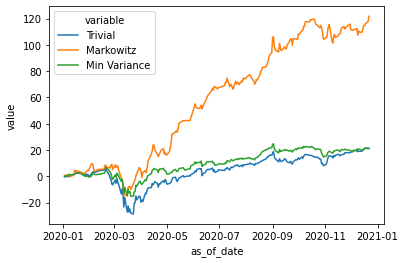

In [37]:
sns.lineplot(data=data, x='as_of_date', y='value', hue='variable');